# Introduction

In this project we want to create a model that can predict the price of a diamond based on its characteristics. 

For this we are going to perform three different procedures. 
On the one hand a linear model, specifically a linear regression model. As a second model we will use an emsabled model such as RandomForest, tuning the hyperparameters with a Bayesian optimization model such as HyperOpt. And finally, we will test the Pycaret library, where we will choose the most appropriate model.

# Data

The Diamonds DataSet has been obtained from Kaggle, at the following [link](https://www.kaggle.com/shivam2503/diamonds). In it, each input is a diamond and the columns correspond to diamond characteristics.

**Predictors Variables** 

 `id`: Input ID.
 
 `carat`: diamond weight.
 
 `cut`: The way in which the diamond facets interact with light.
 
 `clarity`: Purity or transparency of a diamond.
 
 `color`: Color of a diamond.
 
 `table`: Flat part of the upper part.
 
 `x`: Length in mm.

 `y`: Width in mm.
 
 `z`: Depth in mm. 

 `depht`:  Total depth percentage = z / mean(x, y) = 2 * z / (x + y).


**Target Variable**

`price`: Diamond price.

# Libraries

First of all, import the libraries we are going to use.

In [1]:
#import libraries

#data processing
#--------------------------------------------
import pandas as pd
import numpy as np

#graphics
#--------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
%matplotlib inline

#preprocessig
#--------------------------------------------
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from fitter import Fitter, get_common_distributions


#modelling
#--------------------------------------------
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor

#Hyperopt
#---------------------------------------------
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

#Pycaret
#---------------------------------------------
from pycaret.regression import *


#others
#----------------------------------------------
from src.utils import unzip_zip
import warnings
warnings.filterwarnings('ignore')

# Checking Data

## First Approach

Using the `unzip_zip` function contained in `utils.py` in the folder `src`, we unzip the `.csv` files and load them into a Dataframe.

We save the DataFrames in variables.

In [2]:
#unzip and read csv
df_train = unzip_zip("data/diamonds.zip", "diamonds.csv")

Now, let's check the DataFrame

In [3]:
#check data
df_train.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
#check the number, first, of the rows(diamonds) and, second the number of the columns(features)
df_train.shape

(53940, 11)

In [5]:
#check the column's names
df_train.columns

Index(['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table',
       'price', 'x', 'y', 'z'],
      dtype='object')

In [6]:
#check types
df_train.dtypes

Unnamed: 0      int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
price           int64
x             float64
y             float64
z             float64
dtype: object

In [7]:
#check if there are any null value 
df_train.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

It seems that there aren't any null value in the features.

Let's check the target variable: `price`

## Target Variable

The target variable is `price`, it is the value of the diamonds.

As we saw before, the data type of the variable is `int64`.

In [8]:
df_train.price.describe()

count    53940.000000
mean      3932.799722
std       3989.439738
min        326.000000
25%        950.000000
50%       2401.000000
75%       5324.250000
max      18823.000000
Name: price, dtype: float64

As we can see in the table, the total number of diamonds is $53940$, matching what we saw before with the `.shape` method.

We see that the maximum value of a diamond is $18823$ and the minimum is $326$. In addition we have information of the mean, the median(`50%`), the standard deviation(`std`), and the 25th and 75th percentiles.

Let's plot the target variable.

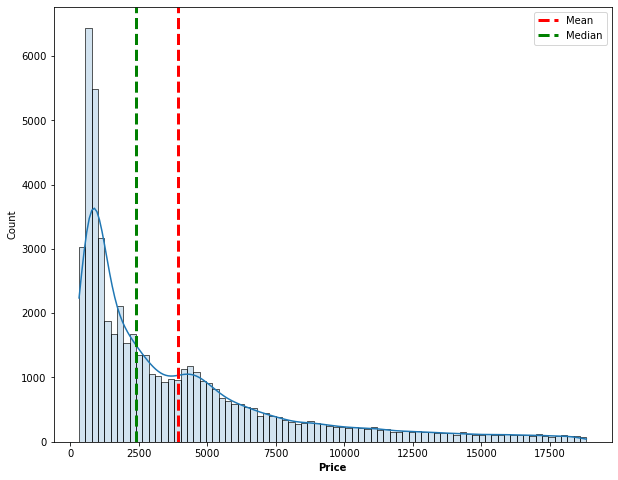

In [9]:
#set graph size
plt.figure(figsize=(10,8))
#set graph type and data
sns.histplot(data=df_train, x="price", kde=True, alpha = 0.2)
#set vertical lines
plt.axvline(x = df_train["price"].mean(), c ="red", linewidth = 3, linestyle = "--", label = "Mean")
plt.axvline(x = df_train["price"].median(), c = "green", linewidth = 3, linestyle = "--", label = "Median")
#modify xlabel
plt.xlabel("Price", fontweight = "bold")
#set legend
plt.legend()
plt.savefig("output/TargetDistributiom.jpg", dpi = 100)
plt.show();

Once the target variable is plotted, we can see that it has an exponential distribution. 

The red line represents the mean, and the green line the median.

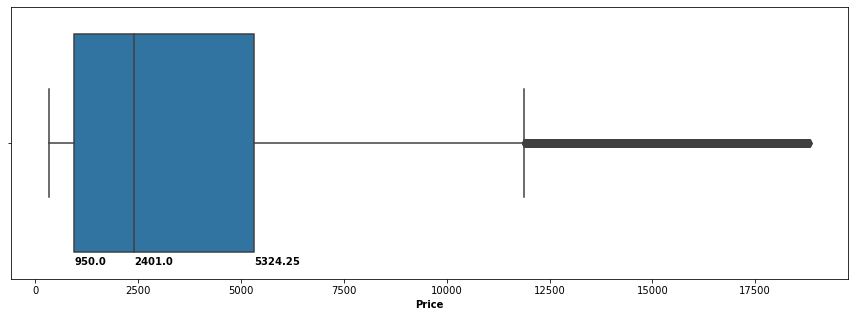

In [11]:
#set graph size
plt.figure(figsize=(15,5))
#set graph type and data
sns.boxplot(data = df_train, x = "price")
#set text into the graph
plt.text(x = df_train["price"].median(), y = 0.45, s = df_train["price"].median(), fontweight = "bold")
plt.text(x = np.percentile(df_train["price"], 75), y = 0.45, s = np.percentile(df_train["price"], 75), fontweight = "bold")
plt.text(x = np.percentile(df_train["price"], 25), y = 0.45, s = np.percentile(df_train["price"], 25), fontweight = "bold")
#modify xlabel
plt.xlabel("Price", fontweight = "bold")
plt.savefig("output/TargetBoxplot.jpg", dpi = 100)
plt.show();

In this boxplot we can graphically check the 25th, 50th(median) and 75th percentiles that we saw previously.

## Numerical Predictors Variables

Next, let's check the distribution of the numeric variables, these are: `carat`, `depth`, `table`, `x`, `y`, and `z`.

We will not take into account the variable `Unnamed: 0`, nor `price`, since we have already seen it in the previous section.

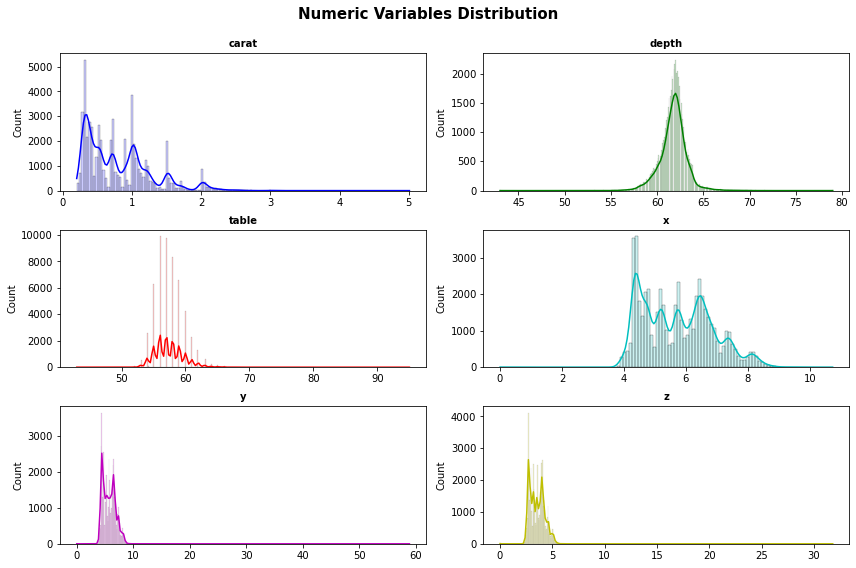

In [12]:
#set subplots number and size
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize=(12, 8))
#using ".flat", we convert the variable "ax" into a 1D array, in order to iterate.
ax = ax.flat
#obtein the numerical column names in an array
numerical_cols = df_train.drop("price", axis=1).select_dtypes(include=["int", "float"]).columns
#set each graph
for ind, col in enumerate(numerical_cols):
#set graph type, color, location, data and other features    
    sns.histplot(data = df_train, 
                 x = col, 
                 color = list(mcolors.BASE_COLORS)[ind], 
                 kde=True, 
                 ax = ax[ind], 
                 alpha=0.2)
#set the title for each graph
    ax[ind].set_title(col, fontsize = 10, fontweight = "bold")
#set empty string to xlabel title
    ax[ind].set_xlabel("")
#set visual config    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle("Numeric Variables Distribution", fontsize = 15, fontweight = "bold")
plt.savefig("output/NumericalDistribution.jpg", dpi = 100)
plt.show();

Thus we can see the distributions of the numerical variables. 

Now, let's see how they relate to the target variable.

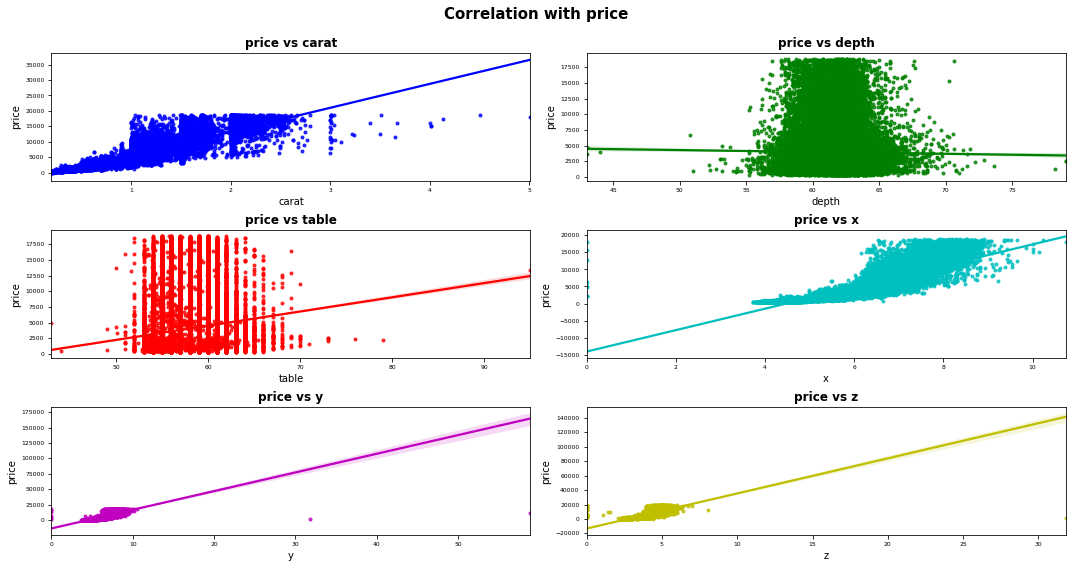

In [13]:
#follow the above steps to adjust the graphs
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize=(15,8))
ax = ax.flat
for ind, cols in enumerate(numerical_cols):
    sns.regplot(x = cols, 
                y = "price", 
                data = df_train, 
                color = list(mcolors.BASE_COLORS)[ind], 
                marker = ".", 
                ax = ax[ind])
    
    ax[ind].set_title(f"price vs {cols}", fontsize = 12, fontweight = "bold")
    ax[ind].tick_params(labelsize = 6)
    ax[ind].set_xlabel(f"{cols}")
    ax[ind].set_ylabel("price")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Correlation with price", fontsize = 15, fontweight = "bold")
plt.savefig("output/Corr_Target_Numerical.jpg", dpi = 100)
plt.show();

We see that in the variables `carat`, `x`, `y`, `z`, there is a positive correlation with the variable target. As for `table`, there seems to be some positive correlation, although in a very weak way. And the `depth` variable has very low correlation with the target variable, and the little correlation that can be seen is negative.

Let us check it by means of a correlation matrix.

In [14]:
#correlation matrix
df_train.drop("Unnamed: 0", axis=1).corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


Here, it can be seen that the `depth` variable is very low and negative.

In addition the variable `table`, if it seems that there is correlation although it is very low.

The rest of the variables seem to have very high correlations with the target variable.

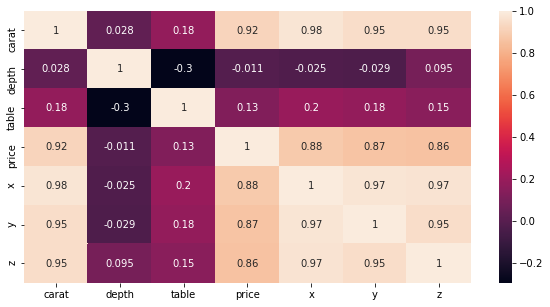

In [16]:
#correlation matrix heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(df_train.drop("Unnamed: 0", axis=1).corr(), annot = True)
plt.savefig("output/Corr_Heatmap.jpg", dpi = 100)
plt.show();

## Categorical Predictors Variables

Next, we will examine the categorical variables, so we will see how they are distributed. These variables are: `cut`, `color`, and `clarity`.


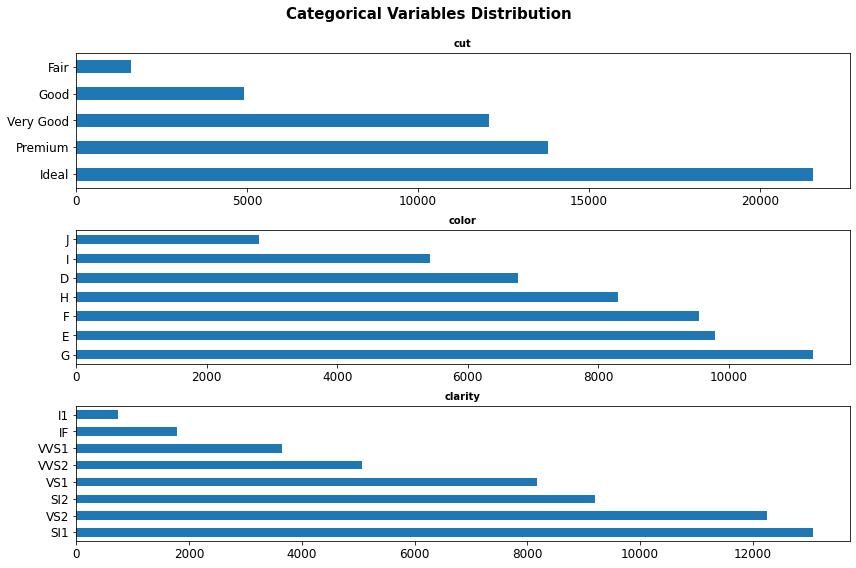

In [17]:
#set subplots and size
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,8))
#set flat
ax = ax.flat
#take categoricals column names
categorical_cols = df_train.select_dtypes(include=["object"]).columns
#set each graph
for ind, cols in enumerate(categorical_cols):
#set data and graph type
    df_train[cols].value_counts().plot.barh(ax=ax[ind])
#set graph config     
    ax[ind].set_title(cols, fontsize=10, fontweight="bold")
    ax[ind].tick_params(labelsize=12)
    ax[ind].set_xlabel("")
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Categorical Variables Distribution", fontsize=15, fontweight="bold")
plt.savefig("output/CategoricalDistribution.jpg", dpi = 100)
plt.show();

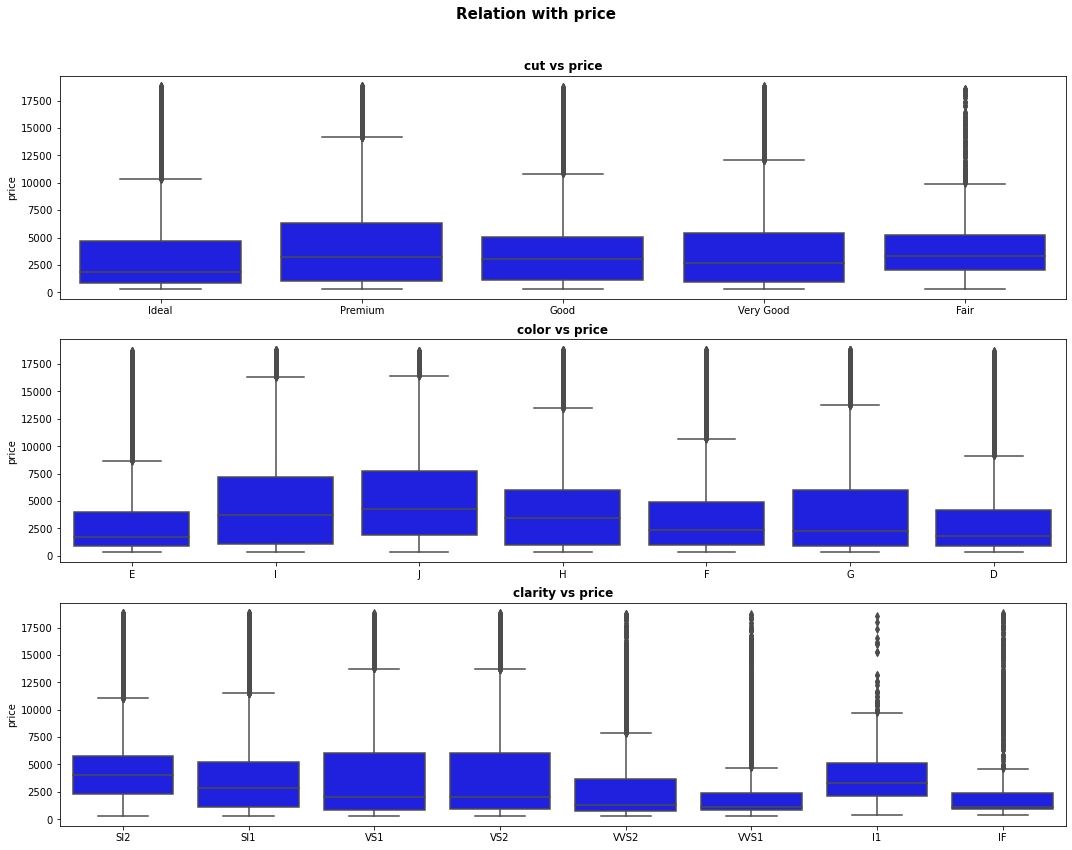

In [18]:
#we plot boxplot of the categorical variables
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(15,12))
ax = ax.flat
for ind, cols in enumerate(categorical_cols):
    sns.boxplot(x = cols, y="price", data=df_train, color="blue", ax=ax[ind])

    ax[ind].set_title(f"{cols} vs price", fontsize = 12, fontweight = "bold")
    ax[ind].set_xlabel("")
    ax[ind].set_ylabel("price")
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Relation with price", fontsize = 15, fontweight = "bold")
plt.savefig("output/Relation_Categorical_Target.jpg", dpi = 100)
plt.show;

# Preprocessing Data

## Dropping ID Variable

As a first action, we will delete the `Unnamed: 0` column because it does not give us any relevant information about the diamonds.

In [19]:
#drop columns: id -> Useless
df_train = df_train.drop("Unnamed: 0", axis=1)

## Encoding Categorical Variables

Now, let's check the values of the `object` type features.

In [20]:
#check uniques
df_train.clarity.unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
      dtype=object)

In [21]:
df_train.cut.unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

In [22]:
df_train.color.unique()

array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object)

Going deeper into the diamond information, we have seen that the values of the three features (`clarity`, `cut`, and `color`) have a scale, that is, they follow an order.

Therefore, our strategy for converting these features to numerical is a hand encoding. By setting values from $1$ -> smallest value, to $n$ -> largest value.

We create dictionaries where the keys are the categorical value and the values are the numerical values that we assign to them.

In [23]:
#review diamond documentation and see that there 
#is numerical order in the categorical features. Encode the categorical features by numerical features.
encoding_cut =  {"Fair":1, "Good":2, 
          "Ideal":3, "Very Good":4, "Premium":5}
    
    
encoding_color = {'E':1,'D':2,'F':3,
             'G':4,'H':5,'I':6,
             'J':7}

encoding_clarity = {'I1':1,'SI2':2,
               'SI1':3,'VS2':4,'VS1':5,
               'VVS2':6,'VVS1':7,'IF':8}

Using the `.apply` method we apply a `lambda` function in which we change the categorical value by the numerical value to each column.

And store the numeric value in the DataFrame column to replace the values.

In [24]:
#replace categorical variables with numerical variables
df_train["cut"] = df_train["cut"].apply(lambda x: encoding_cut[x])
df_train["color"] = df_train["color"].apply(lambda x: encoding_color[x])
df_train["clarity"] = df_train["clarity"].apply(lambda x: encoding_clarity[x])

## Ols Regression

By means of `ols` we will check the influence of the variables on the target variable.

In [23]:
#Let's get the summary of the metrics.
#Set 'price' as target variable, and the rest as predictors variables. And, them, fit the model.
train_results = smf.ols(
    "price ~ carat + cut + color + clarity + table  + x + depth + y + z",
    data=df_train).fit()
#We see the summary
train_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 5.717e+04
Date:                Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:03:31   Log-Likelihood:            -4.6025e+05
No. Observations:               53940   AIC:                         9.205e+05
Df Residuals:                   53930   BIC:                         9.206e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8849.2308    380.670     23.246      0.000    8103.114    9595.348
carat       1.069e+04     52.347    204.167      0.000    1.06e+04    1.08e+04
cut           92.8488      5.307     17.497      0.000      82.448     103.250
color       -294.3752      3.161    -93.140      0.000    -300.570    -288.180
clarity      502.5583      3.540    141.962      0.000     495.620     509.497
table        -67.1239      2.584    -25.976      0.000     -72.189     -62.059
x           -859.8736     35.576    -24.170      0.000    -929.604    -790.143
depth        -98.6111      4.647    -21.223      0.000    -107.718     -89.504
y             41.7165     20.960      1.990      0.047       0.634      82.799
z            -38.6496     36.378     -1.062      0.288    -109.952      32.653
==============================================================================
Omnibus:                    12166.846   Durbin-Watson:                   1.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           621515.145
Skew:                          -0.085   Prob(JB):                         0.00
Kurtosis:                      19.629   Cond. No.                     6.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we can see, the `R-squared` label has a value of `0.952`. `R-squared` is the percentage of variation of the target variable that explains its relationship with one or more predictor variables. This value is between $0$ and $1$, and the closer to $1$ the better the fit of the model to data.

As can be seen the value of the variable `z` in $P>|t|$ is greater than $0.05$, so we will proceed to drop it.

In [25]:
#drop colums: z
df_train = df_train.drop("z", axis=1)

In [25]:
#recheck summary
train_results = smf.ols(
    "price ~ carat + cut + color + clarity + table + depth + x + y",
    data=df_train).fit()
#We see the summary
train_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 6.432e+04
Date:                Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:03:31   Log-Likelihood:            -4.6026e+05
No. Observations:               53940   AIC:                         9.205e+05
Df Residuals:                   53931   BIC:                         9.206e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8985.4617    358.425     25.069      0.000    8282.946    9687.978
carat       1.069e+04     52.346    204.164      0.000    1.06e+04    1.08e+04
cut           92.9234      5.306     17.512      0.000      82.523     103.323
color       -294.3483      3.160    -93.134      0.000    -300.543    -288.154
clarity      502.5078      3.540    141.960      0.000     495.570     509.446
table        -67.0927      2.584    -25.965      0.000     -72.157     -62.028
depth       -100.8685      4.132    -24.410      0.000    -108.968     -92.769
x           -880.4633     29.835    -29.511      0.000    -938.940    -821.987
y             38.7076     20.768      1.864      0.062      -1.998      79.414
==============================================================================
Omnibus:                    12169.270   Durbin-Watson:                   1.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           622005.836
Skew:                          -0.085   Prob(JB):                         0.00
Kurtosis:                      19.635   Cond. No.                     5.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We save the cleaned DataFrame in a `.csv` file.

In [26]:
#convert to .csv
df_train.to_csv("input/train_clean.csv", header=True, index=False)

# Creating Models

## Split DataFrame

In order to have a DataSet that is not known to the models and to be able to test it with new data, we will split the DataFrame in two. We are going to make a very simple separation. About 20% of the end of the DataFrame will be the test sample.

We have to make this separation, since PyCaret performs its modeling with the entire DataFrame, and it would not make sense to predict the `y_test`, because the model would already know its values.

In [26]:
df_test = df_train[43_100:]
df_train = df_train[:43_100]

## X Y Split

To begin, we will perform a linear regression model as a means of predicting the price of diamonds based on the predictor variables we saw earlier.

We set the variable `X` for the predictor variables, and the variable `y` for the target variable.

In [27]:
#take predictors variables and response variable
X = df_train.drop("price", axis=1)
y = df_train["price"]
df_testX = df_test.drop("price", axis=1)
df_testy = df_test["price"]

## Train Test Split

We use the `train_test_split` method to split the `X` and `y` into a 0.8 train and a 0.2 test.

We will train the model with the 0.8 selected by the method and test it with the 0.2 of the test.

In [28]:
#split the data 0.8 traon, 0.2 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=444)

## Random Forest Regressor

The first model we are going to train is a Random Forest Regressor. It is a bagging method which uses Decision Trees as a simple model.

For more info, [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) is the documentation.

First we will train the default model, and we will calculate its `RMSE`(root mean square error). This metric, which is the square root of the `MSE`(root mean square error), will be used to make it easier to interpret, because the values are on the same scale as the target variable.

Subsequently, we will train a Random Forest Regressor model, but we will tune the hyperparameters using the `HyperOpt` library.

### Fit Model

We train the model, make the predictions and calculate the `RMSE`.

In [30]:
#set the model, and asign to a variable
rf = RandomForestRegressor()
#train the model with train set
rf.fit(X_train, y_train)
#perform the prediction with the test set, to obtain the predicted `y` test.
y_rf_pred = rf.predict(X_test)
#compute RMSE
rfreg_rmse = mse(y_test, y_rf_pred)**0.5
#print RMSE
print(f"The RMSE of the RandomForestRegressor model is {rfreg_rmse}")

The RMSE of the RandomForestRegressor model is 592.1286025559468


### RF Test

We train the test, and calculate the `RMSE`.

In [31]:
rf.fit(X, y)
y_rf_pred = rf.predict(df_testX)
rfreg_rmse = mse(df_testy, y_rf_pred)**0.5
print(f"The RMSE of the RandomForestRegressor model is {rfreg_rmse}")

The RMSE of the RandomForestRegressor model is 511.27775312909534


We will create a DataFrame where the real data and the predictions of each model will be found.

In [32]:
#create DataFrame
pred_df = pd.DataFrame({"Real":df_testy, "RF": y_rf_pred})
pred_df.head()

,Real,RF
43100,1383,1286.41
43101,1384,1251.04
43102,1384,1327.92
43103,1384,1349.46
43104,1384,1298.48


### Tune Hiperparameters

We continue training the previous model, but we are going to tune the hyperparameters of the model with the HyperOpt library.

HyperOpt is a hyperparameter optimizer based on Bayesian optimization. 

[Here](http://hyperopt.github.io/hyperopt/) is the documentation for more information.

To begin with, we are going to create a dictionary where we will put the search space.

In [33]:
#set the search parameters
params = {
        "n_estimators":hp.quniform("n_estimators", 10, 1000, 25),
        "max_depth":hp.quniform("max_depth", 4, 16, 1),
        "max_features":hp.quniform("max_features",2 ,8, 1),
        "min_samples_split":hp.quniform("min_samples_split", 2, 15, 1),
        "min_samples_leaf":hp.quniform("min_samples_leaf", 1,5,1)
}

Once our search parameters are set, we have to define an objective function, on which the `fmin` function will have to minimize.

In [34]:
#define an objetive function
def objetive(param):

    rf = RandomForestRegressor(n_estimators=int(param["n_estimators"]),
                      max_depth=int(param["max_depth"]),
                      max_features=int(param["max_features"]),
                      min_samples_split=int(param["min_samples_split"]),
                      min_samples_leaf=int(param["min_samples_leaf"]))
    
   
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
   
    rmse = mse(y_test, y_pred)**(0.5)
    
    return {"loss":rmse, "status": STATUS_OK }

With the search parameters and the objective function, the search for the best set of hyperparameters can begin.

In [35]:
#minimize the objective over the parameters
trials_reg = Trials()
best = fmin(fn=objetive,
            space=params,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials_reg
            )

100%|██████████| 10/10 [03:58<00:00, 23.81s/trial, best loss: 626.4104309159584]


We check the best combination of hyperparameters for our data.

In [36]:
#check the best
best

{'max_depth': 12.0,
 'max_features': 3.0,
 'min_samples_leaf': 1.0,
 'min_samples_split': 6.0,
 'n_estimators': 850.0}

From here, we follow the same process as before, set up the model, train it, and calculate the `RMSE`.

In [37]:
#set model with the best hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=int(best["n_estimators"]),
    max_depth=int(best["max_depth"]),
    max_features=int(best["max_features"]),
    min_samples_split=int(best["min_samples_split"]),
    min_samples_leaf=int(best["min_samples_leaf"])
)

In [38]:
#fit model and check RMSE
rf_model.fit(X_train, y_train)
y_pred_test_rf=rf_model.predict(X_test)
rmse_rf = mse(y_test, y_pred_test_rf)**0.5
print(f"The RMSE of the tuned RandomForestRegressor model is {rmse_rf}")

The RMSE of the tuned RandomForestRegressor model is 627.9295708205129


And, we include the predictions in the DataFrame.

### Tuned RF Test

We train the test, and calculate the `RMSE`.

In [39]:
#fit an compute RMSE
rf_model.fit(X, y)
y_pred_test_rf = rf_model.predict(df_testX)
rmse_rf = mse(df_testy, y_pred_test_rf)**0.5
print(f"The RMSE of the RandomForestRegressor model is {rmse_rf}")

The RMSE of the RandomForestRegressor model is 482.12133102697754


In [40]:
#include the predictions to the DataFrame
pred_df["RF_HyperOpt"] = y_pred_test_rf
pred_df.head()

,Real,RF,RF_HyperOpt
43100,1383,1286.41,1228.987295
43101,1384,1251.04,1278.767638
43102,1384,1327.92,1242.252627
43103,1384,1349.46,1283.429167
43104,1384,1298.48,1269.057161


## Pycaret

Next, we are going to test the PyCaret library, a low code library in which setting our data, the target variable, will select the best model that fits our data, among other things.

For more information, [here](https://pycaret.org/) is the documentation.

### Fit Model

We are going to transform the type of the categorical variables into `float`.

In [41]:
df_train[["cut", "color", "clarity"]] = df_train[["cut", "color", "clarity"]].apply(lambda x:x.astype("float64"))

In [42]:
df_train.dtypes

carat      float64
cut        float64
color      float64
clarity    float64
depth      float64
table      float64
price        int64
x          float64
y          float64
dtype: object

We set our DataFrame, and the target variable.

In [43]:
exp_clf101 = setup(data = df_train, target = "price", train_size = 0.8, remove_perfect_collinearity = False, session_id=123)

,Description,Value
0,session_id,123
1,Target,price
2,Original Data,"(43100, 9)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(34480, 8)"


The compare_models() function will look for the model that best fits our data. 

There are many default models. But there are some that must be installed previously. In my case, for example, I had to install `XGBoost`.

In [44]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,317.8772,346497.2573,587.7632,0.9811,0.1093,0.0847,0.4760
xgboost,Extreme Gradient Boosting,311.5082,355883.6406,595.8926,0.9806,0.0940,0.0708,1.5140
rf,Random Forest Regressor,307.0564,362117.5153,601.2460,0.9802,0.0895,0.0645,5.7620
et,Extra Trees Regressor,303.1929,366018.5408,604.3555,0.9800,0.0896,0.0639,4.5590
gbr,Gradient Boosting Regressor,386.2608,462119.9746,679.2389,0.9748,0.1619,0.1110,1.7260
dt,Decision Tree Regressor,409.7213,678273.4670,823.3485,0.9630,0.1230,0.0842,0.1730
knn,K Neighbors Regressor,548.8212,990728.3812,994.5999,0.9460,0.1807,0.1386,0.2010
ada,AdaBoost Regressor,850.6413,1476602.8734,1214.5504,0.9194,0.3178,0.2996,1.1740
lasso,Lasso Regression,909.8679,1738813.0000,1318.1722,0.9050,0.7104,0.4911,0.1760
lr,Linear Regression,909.1101,1740642.6375,1318.7160,0.9049,0.7120,0.4912,0.9710


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

You can see, that compare_models() gives us a list of all models with their metrics. In this case, we are looking for the RMSE so we will stick with the `LightGBM`. It also has the best `R2` score, an aspect to take into account.

More information about `LightGBM` [here](https://lightgbm.readthedocs.io/en/latest/).

Once we have selected the model we want to use, we create the model using the `create_model` function and assign it to a variable.

In [45]:
lgbm_reg = create_model("lightgbm")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,307.2452,294976.0477,543.1170,0.9841,0.1084,0.0851
1,320.2320,335828.5261,579.5071,0.9825,0.1083,0.0847
2,321.1319,336827.4491,580.3684,0.9819,0.1098,0.0852
3,308.5142,328650.3164,573.2803,0.9809,0.1057,0.0827
4,325.9656,404640.1982,636.1134,0.9773,0.1089,0.0838
5,324.6827,380648.6433,616.9673,0.9794,0.1105,0.0859
6,318.1790,339750.9557,582.8816,0.9816,0.1097,0.0847
7,332.6402,410294.3818,640.5423,0.9781,0.1150,0.0864
8,316.2028,337820.1570,581.2230,0.9815,0.1112,0.0856
9,303.9783,295535.8974,543.6321,0.9835,0.1057,0.0827


We performed the model predictions.

To create the model, PyCaret performs splits of the DataFrame, using the `finalize_model` function we train the model with the entire DataFrame.

In [46]:
final_lgbm = finalize_model(lgbm_reg)

We make predictions.

In [47]:
predict_model(final_lgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,301.5862,285640.9974,534.4539,0.9851,0.1052,0.0816


,carat,cut,color,clarity,depth,table,x,y,price,Label
0,0.72,3.0,2.0,3.0,60.500000,56.0,5.79,5.84,3550.0,3241.344530
1,1.52,4.0,3.0,5.0,63.799999,56.0,7.25,7.30,15819.0,15493.783551
2,0.91,4.0,3.0,4.0,63.400002,55.0,6.22,6.18,4434.0,4642.447623
3,1.06,4.0,3.0,2.0,60.000000,59.0,6.60,6.63,4224.0,4318.669674
4,0.40,4.0,2.0,2.0,63.400002,56.0,4.73,4.67,855.0,766.088832
...,...,...,...,...,...,...,...,...,...,...
8615,0.31,4.0,5.0,7.0,63.299999,58.0,4.32,4.28,907.0,763.017655
8616,0.50,3.0,1.0,2.0,63.000000,57.0,5.09,5.04,1181.0,1105.811315
8617,0.32,3.0,4.0,7.0,62.000000,57.0,4.42,4.38,1080.0,875.261265
8618,0.41,5.0,1.0,3.0,61.200001,59.0,4.82,4.78,904.0,884.355404


### LGMB Test

We train the test, and calculate the `RMSE`.

In [48]:
y_pred_lgbm = final_lgbm.predict(df_testX)

In [49]:
rmse_lgbm = mse(df_testy, y_pred_lgbm)**0.5
print(f"The RMSE of the LGBM model is {rmse_lgbm}")

The RMSE of the LGBM model is 401.045401978966


In [50]:
#add predictions to DataFrame
pred_df["LGBM"] = y_pred_lgbm
pred_df.head()

,Real,RF,RF_HyperOpt,LGBM
43100,1383,1286.41,1228.987295,1117.772805
43101,1384,1251.04,1278.767638,1184.937729
43102,1384,1327.92,1242.252627,1248.686534
43103,1384,1349.46,1283.429167,1369.501028
43104,1384,1298.48,1269.057161,1259.586743


### Tune Hyperparameters

As with the previous model, we are going to tune the hyperparameters. In this case we are going to use the `tune_model` function and we are going to select the `tpe` algorithm.

In [51]:
tune_lgbm = tune_model(lgbm_reg, search_library="optuna", search_algorithm="tpe")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,303.9530,309175.4867,556.0355,0.9834,0.1178,0.0707
1,317.3204,348820.4021,590.6102,0.9818,0.0939,0.0707
2,317.9675,360068.3745,600.0570,0.9806,0.0970,0.0710
3,305.3528,349118.9037,590.8628,0.9797,0.0952,0.0706
4,326.6002,416598.9295,645.4448,0.9766,0.0980,0.0727
5,327.4146,424950.9015,651.8826,0.9769,0.1009,0.0730
6,320.5794,369977.5550,608.2578,0.9799,0.0950,0.0712
7,324.9859,429739.5431,655.5452,0.9771,0.1023,0.0722
8,308.0977,348855.2598,590.6397,0.9809,0.0989,0.0705
9,306.6114,323230.1996,568.5334,0.9820,0.0950,0.0698


We fit the model and compute the `RMSE`.

In [52]:
finalize_t_lgbm = finalize_model(tune_lgbm)

### Tuned LGBM Test

We train the test, and calculate the `RMSE`.

In [53]:
y_pred_tune_lgbm = finalize_t_lgbm.predict(df_testX)
rmse_t_lgbm = mse(df_testy, y_pred_tune_lgbm)**0.5
print(f"The RMSE of the tuned LGBM model is {rmse_t_lgbm}")

The RMSE of the tuned LGBM model is 328.49112940886306


In [54]:
pred_df["Tuned_LGBM"] = y_pred_tune_lgbm
pred_df.reset_index(drop=True)
pred_df.head()

,Real,RF,RF_HyperOpt,LGBM,Tuned_LGBM
43100,1383,1286.41,1228.987295,1117.772805,1161.242646
43101,1384,1251.04,1278.767638,1184.937729,1262.594717
43102,1384,1327.92,1242.252627,1248.686534,1279.774685
43103,1384,1349.46,1283.429167,1369.501028,1279.409887
43104,1384,1298.48,1269.057161,1259.586743,1118.462096


# Conclusion

We will now compare the `RMSE` of each model.

In [55]:
#create DataFrame with the RMSE of the models
df_error = pd.DataFrame({
                        "Model": ["RamdomForest","RandomForest_HyperOpt", "LGBM", "Tuned_LightGBM"],
                        "RMSE": [rfreg_rmse, rmse_rf, rmse_lgbm, rmse_t_lgbm]
                     }).sort_values("RMSE", ascending=False)
df_error

,Model,RMSE
0,RamdomForest,511.277753
1,RandomForest_HyperOpt,482.121331
2,LGBM,401.045402
3,Tuned_LightGBM,328.491129


Plot the RMSE results

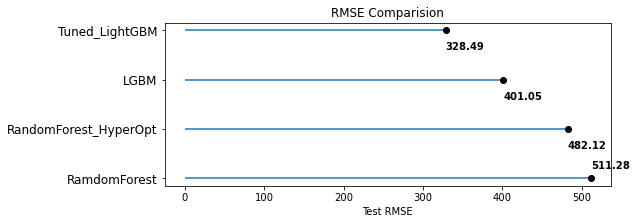

In [56]:
plt.figure(figsize=(8,3))
plt.hlines(df_error.Model, xmin=0, xmax=df_error.RMSE)
plt.plot(df_error.RMSE, df_error.Model, "o", color="black")
plt.tick_params(axis="y", labelsize=12)
plt.title("RMSE Comparision")
plt.xlabel("Test RMSE")
plt.text(x = rfreg_rmse, y=0.2, s = rfreg_rmse.round(2), fontdict={"weight": "bold","size": 10})
plt.text(x = rmse_rf, y=0.6, s=rmse_rf.round(2), fontdict={"weight": "bold","size": 10})
plt.text(x = rmse_lgbm, y=1.6, s=rmse_lgbm.round(2), fontdict={"weight": "bold","size": 10})
plt.text(x = rmse_t_lgbm, y=2.6, s=rmse_t_lgbm.round(2), fontdict={"weight": "bold","size": 10})
plt.savefig("output/Comparative_errors.jpg", dpi = 100)
plt.show;

Looking at the RMSE comparison, we can see that the best model (the one with the lowest RMSE) is the LightGBM with the tuned hyperparameters, followed by the default LightGBM created by PyCaret. 

<AxesSubplot:ylabel='Density'>

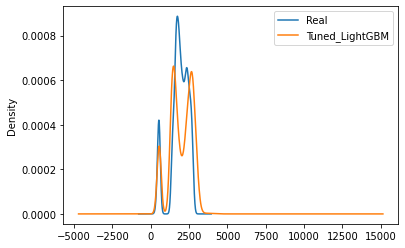

In [45]:
pred_df.plot.kde()

Finally, here we can see the density of the real target variable with the prediction of the Light Gradient Boosting Machine tuned model.

Save the model.

In [63]:
save_model(finalize_t_lgbm, "LightGBM_opt_tpe")

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='price',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='...
                                importance_type='split',
                                learning_rate=0.2512630986200139, max_depth=-1,
                                min_child_samples=83, min_child_weight=0.001,
                                min_split_gain=0.4665499623927324,
                               